# Hyytiälä 2018 figures for pyAPES 1.0 manuscript

## Load environmental variablesa and set pyAPES into path

In [21]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
hyytiala_forcing = os.getenv('HYYTIALA_FORCING')
lad_data = os.getenv('HYYTIALA_LAD_PROFILES')
hyytiala_data_folder = os.getenv('HYYTIALA_2018_DATA')

sys.path.append(pyAPES_main_folder)

## Imports

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re

from sklearn.metrics import r2_score

from pyAPES.utils.iotools import read_data
from pyAPES_utilities.timeseries_tools import diurnal_cycle
from pyAPES.utils.iotools import read_forcing
from pyAPES.microclimate.micromet import e_sat
%matplotlib widget

In [23]:
sns.set_context('paper', font_scale=1.5)

In [24]:
forcing = read_forcing('../../forcing/Hyytiala/FIHy_forcing_2018.dat', start_time='20180401', end_time='20181031')

In [25]:
forcing

,doy,Prec,P,Tair,Tdaily,U,Ustar,H2O,CO2,Zen,LWin,diffPar,dirPar,diffNir,dirNir,X,DDsum,Tsa,Wa,Rew
2018-04-01 00:00:00,91.0,0.0,99109.370,-0.943,-0.695,1.663,0.067,0.002006,417.713,1.992,219.944,0.0,0.000,0.0,0.000,-4.247,0.000,0.855,0.321,1.000
2018-04-01 00:30:00,91.0,0.0,99109.130,-0.783,-0.695,1.550,0.077,0.001953,417.628,1.996,220.465,0.0,0.000,0.0,0.000,-4.247,0.000,0.847,0.321,1.000
2018-04-01 01:00:00,91.0,0.0,99113.464,-0.526,-0.695,1.437,0.087,0.001853,417.106,1.990,221.298,0.0,0.000,0.0,0.000,-4.247,0.000,0.860,0.321,1.000
2018-04-01 01:30:00,91.0,0.0,99104.130,-0.875,-0.695,1.325,0.096,0.001873,416.805,1.977,220.169,0.0,0.334,0.0,0.408,-4.247,0.000,0.854,0.321,1.000
2018-04-01 02:00:00,91.0,0.0,99102.500,-2.298,-0.695,0.971,0.079,0.001922,416.987,1.954,215.604,0.0,0.386,0.0,0.472,-4.247,0.000,0.865,0.321,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-30 22:00:00,303.0,0.0,99818.430,0.898,-1.709,5.760,1.274,0.006532,413.931,2.214,242.327,0.0,2.916,0.0,3.564,2.153,1840.219,3.765,0.190,0.593
2018-10-30 22:30:00,303.0,0.0,99818.270,1.020,-1.709,5.336,1.337,0.006589,414.198,2.250,242.893,0.0,3.032,0.0,3.706,2.153,1840.219,3.769,0.190,0.593
2018-10-30 23:00:00,303.0,0.0,99791.100,1.077,-1.709,5.621,1.251,0.006617,414.394,2.278,243.232,0.0,3.031,0.0,3.704,2.153,1840.219,3.772,0.190,0.593
2018-10-30 23:30:00,303.0,0.0,99760.236,1.091,-1.709,5.940,1.246,0.006626,414.345,2.297,243.415,0.0,3.053,0.0,3.731,2.153,1840.219,3.770,0.190,0.593


In [26]:
np.pi/2

1.5707963267948966

In [27]:
sns.set_context('paper', font_scale=1.5)

## Load Hyytiälä 2018 simulation data

To produce simdata run Demo_hyytiala_2018.ipynb

In [28]:
simdata = xr.open_dataset('../../results/FiHy2018.nc')

In [29]:
def summarize_data_variable(data, column_names, z, simulation, planttype=None):

    df = pd.DataFrame(index=z, columns=column_names)
    
    if planttype is not None:
        data_selected = data.sel(simulation=simulation, planttype=planttype)
    else:
        data_selected = data.sel(simulation=simulation)
    # Check that there dims are now ('date','canopy')
    if not data_selected.dims==('date','canopy'):
        print('After selection data dimensions are not (date, canopy). Please check simulation number and planttype number')
        return pd.DataFrame()
    for col in column_names:
        if col == 'median':
            df[col] = data_selected.median(dim='date')
        elif col == 'mean':
            df[col] = data_selected.mean(dim='date')
        else:
            # calculate percentiles
            percentile = int(re.findall(r'\d+', col)[0])
            df[col] = data_selected.quantile(percentile/100, dim='date')
    return df


In [30]:
percentiles = [5, 25, 75, 95]
vars = ['pt_net_co2','pt_leaf_temperature','canopy_wind_speed']
#vars = ['canopy_wind_speed']
res = {}
df_columns = ['mean', 'median'] + [f'{i}th' for i in percentiles]

hour_start = 10
hour_end = 14
month_start = 5
month_end = 9

time_mask = ((simdata.date.dt.month >= month_start) & (simdata.date.dt.month <= month_end) & (
    simdata.date.dt.hour >= hour_start) & (simdata.date.dt.hour <= hour_end))

data_time_mask = simdata.sel(date=time_mask)
for i, var in enumerate(vars):
    if 'canopy' not in data_time_mask[var].dims:
        print(f'Canopy not in {var} dimensions')
        print('Omitting')
        continue
    if 'planttype' in data_time_mask[var].dims:
        num_planttypes = len(data_time_mask.canopy_planttypes)
    else:
        num_planttypes = 0
    if 'simulation' in data_time_mask[var].dims:
        num_simulations = len(data_time_mask.simulation)
    else:
        num_simulations = 1

    if num_planttypes == 0 and num_simulations < 2:
        # No need to loop over planttypes
        # Only one simulation, no need to loop over simulations
        res_key = f'{var}'
        res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0)
    elif num_planttypes > 0 and num_simulations < 2:
        # Loop over planttypes but do not loop over simulations
        for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
            res_key = f'{var}_{pt}'
            res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0, pt_ind)

    elif num_planttypes == 0 and num_simulations >= 1:
        # Loop over simulations but no need to loop over planttypes
        for sim_ind in simdata.simulation.values:
            res_key = f'{var}_{sim_ind}'
            res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind)

    elif num_planttypes > 0 and num_simulations >= 1:
        # Loop over simulations and planttypes
        for i in simdata.simulation.values:
            for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
                res_key = f'{var}_{pt}_{i}'
                res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind, pt_ind)

/Users/opa/pyAPES_main/.venv/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/opa/pyAPES_main/.venv/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/opa/pyAPES_main/.venv/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/opa/pyAPES_main/.venv/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


## Vertical profiles for selected variables

In [31]:
def vertical_canopy_profile(data:xr.Dataset, month_start=1, month_end=12, hour_start:int=0, hour_end:int=23):
    """Computes vertical profile of environmental data

    Args:
        data (xr.Dataset): environmental data where index = pd.datetime, i.e. '1996-01-01 00:30:00'
        hour_start (int, optional): _description_. Defaults to 0.
        hour_end (int, optional): _description_. Defaults to 23.

    Returns:
        dict: keys == data.columns
                    values == pd.dataframe where
                                columns = ['hour', 'minu', 'N', 'mean', 'std', 'se',
                                           'median', '5th', '25th', '75th', '95th'
                                          ]
    """    

    percentiles = [5, 25, 75, 95]
    vars = ['pt_net_co2','pt_leaf_temperature','canopy_wind_speed']
    #vars = ['canopy_wind_speed']
    res = {}
    df_columns = ['mean', 'median'] + [f'{i}th' for i in percentiles]

    hour_start = 10
    hour_end = 14
    month_start = 5
    month_end = 9

    time_mask = ((simdata.date.dt.month >= month_start) & (simdata.date.dt.month <= month_end) & (
        simdata.date.dt.hour >= hour_start) & (simdata.date.dt.hour <= hour_end))

    data_time_mask = simdata.sel(date=time_mask)
    for i, var in enumerate(vars):
        if 'canopy' not in data_time_mask[var].dims:
            print(f'Canopy not in {var} dimensions')
            print('Omitting')
            continue
        if 'planttype' in data_time_mask[var].dims:
            num_planttypes = len(data_time_mask.canopy_planttypes)
        else:
            num_planttypes = 0
        if 'simulation' in data_time_mask[var].dims:
            num_simulations = len(data_time_mask.simulation)
        else:
            num_simulations = 1

        if num_planttypes == 0 and num_simulations < 2:
            # No need to loop over planttypes
            # Only one simulation, no need to loop over simulations
            res_key = f'{var}'
            res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0)
        elif num_planttypes > 0 and num_simulations < 2:
            # Loop over planttypes but do not loop over simulations
            for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
                res_key = f'{var}_{pt}'
                res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, 0, pt_ind)

        elif num_planttypes == 0 and num_simulations >= 1:
            # Loop over simulations but no need to loop over planttypes
            for sim_ind in simdata.simulation.values:
                res_key = f'{var}_{sim_ind}'
                res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind)

        elif num_planttypes > 0 and num_simulations >= 1:
            # Loop over simulations and planttypes
            for i in simdata.simulation.values:
                for pt_ind,pt in enumerate(data_time_mask.canopy_planttypes.values):
                    res_key = f'{var}_{pt}_{i}'
                    res[res_key] = summarize_data_variable(data_time_mask[var],df_columns, data_time_mask.canopy_z, sim_ind, pt_ind)

    return res

### Add new incident par radiation variable to results

In [32]:
simdata['canopy_absorbed_par'] = simdata['canopy_par_absorbed_sunlit']*simdata['canopy_sunlit_fraction'] + simdata['canopy_par_absorbed_shaded']*(1-simdata['canopy_sunlit_fraction'])

In [33]:
# fig, ax = plt.subplots()
# date_target = '201806011200'
# ind_date = np.argmax(simdata.date.values > pd.to_datetime('201806011200'))
# ax.plot(simdata['canopy_absorbed_par'][ind_date, 0, :], simdata['canopy_z'])

In [34]:
variables = ['canopy_wind_speed','pt_leaf_temperature','pt_net_co2','canopy_absorber_par', ]

## GPP for individual levels per plant type

In [35]:
pt_net_co2_daily = simdata.pt_net_co2.resample(date='D').mean()

In [36]:
species_ind = [i for i, name in enumerate(simdata.canopy_planttypes.data) if name in ['decid','pine','spruce']]

In [37]:
lad_normed = pd.read_csv('../../forcing/Hyytiala/lad_profiles_normed.dat', sep=';', header=None).rename(
    columns={0:'z',1:'pine',2:'spruce', 3:'decid'}).set_index('z')

In [38]:
lad_normed

,pine,spruce,decid
z,,,
0.00,0.000000,0.000000,0.000000
0.25,0.000000,0.000000,0.000000
0.50,0.000003,0.018660,0.004962
0.75,0.000012,0.041208,0.010529
1.00,0.000024,0.058451,0.014515
...,...,...,...
24.00,0.000000,0.006460,0.000000
24.25,0.000000,0.004592,0.000000
24.50,0.000000,0.004751,0.000000


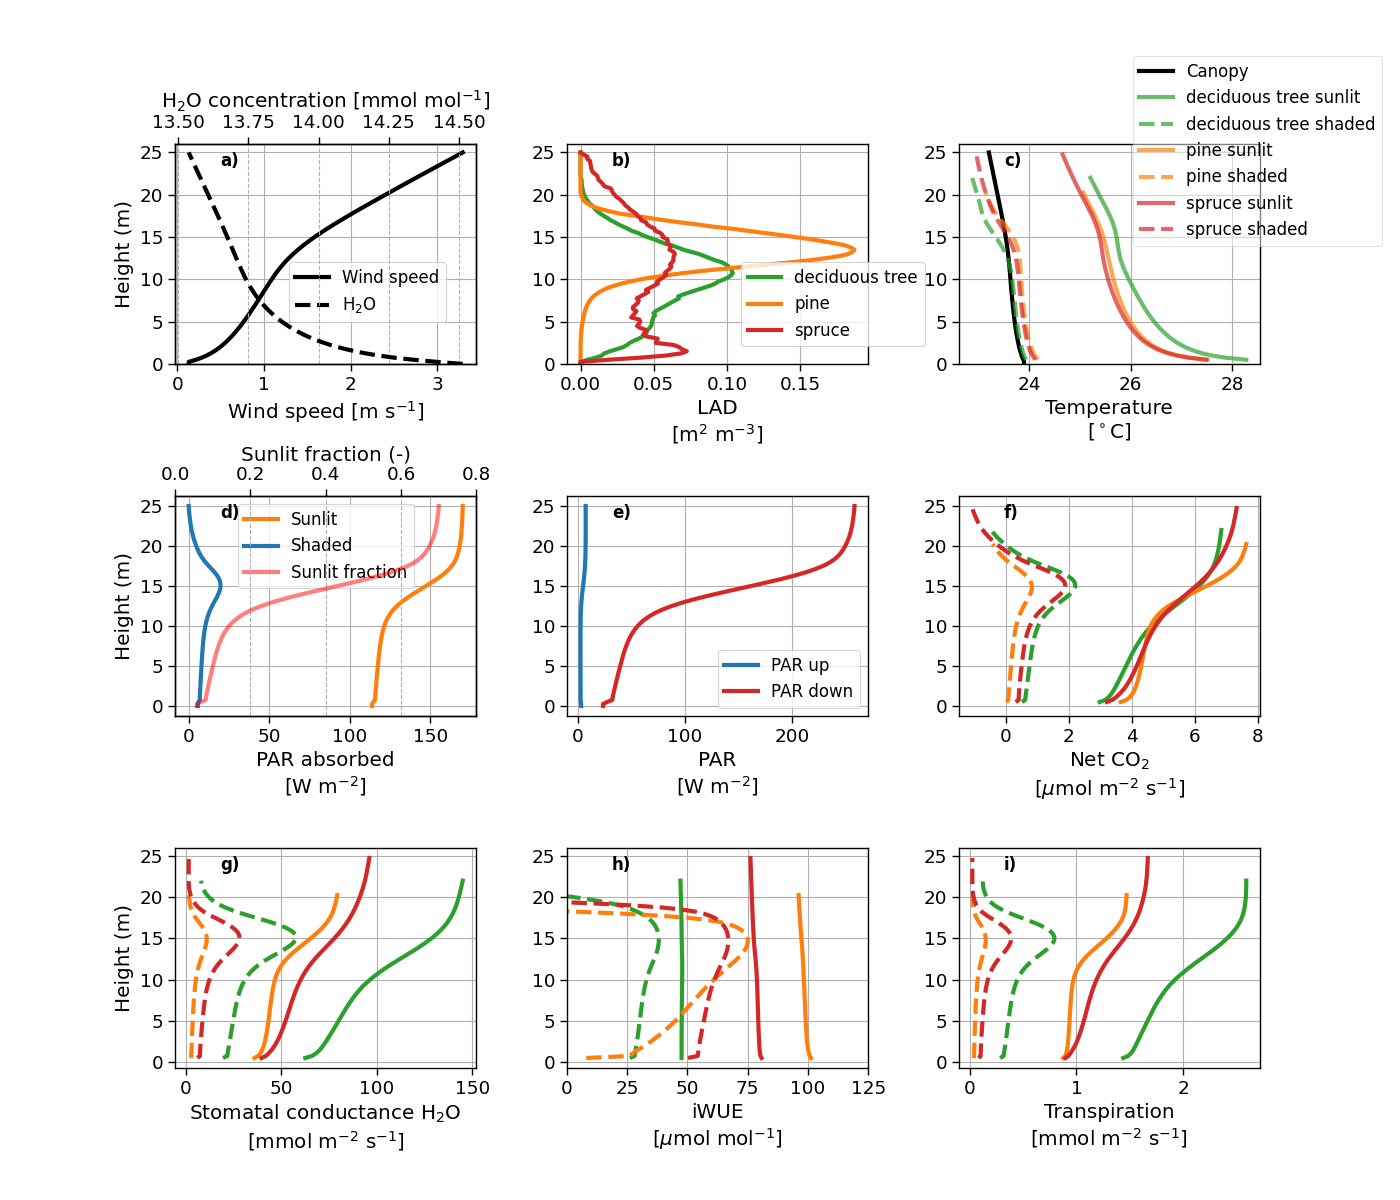

In [42]:
#-- Alpha for LAD profiles (adjust as needed) --
lad_alpha = 0.3

#-- Line width for all plots --
lw = 3

#-- Planttypes to plot (indices [0,1,3]) --
planttype_indices = [0, 1, 3]
planttypes = ['deciduous tree', 'pine', 'spruce']
planttype_names = ['decid', 'pine', 'spruce']
colors = ['tab:green', 'tab:orange', 'tab:red']

#-- Select dry days in July between 10-14 hours --
# Filter for July and hours 10-14
july_mask = simdata.date.dt.month == 7
hour_mask = (simdata.date.dt.hour >= 10) & (simdata.date.dt.hour <= 14)
time_mask = july_mask & hour_mask

# Calculate 48-step rolling sum of precipitation
precip_rolling = simdata.forcing_precipitation.rolling(date=48, min_periods=48).sum()

# Filter for dry periods (rolling sum == 0)
dry_mask = precip_rolling == 0

# Combine all masks
final_mask = (time_mask & dry_mask).values.flatten()

# Select data and take mean
sel_data = simdata.sel(date=final_mask, simulation=0).mean(dim='date')

#-- Get canopy height --
canopy_z = sel_data['canopy_z'].values

#-- Create figure with 3x3 grid --
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.6, wspace=0.3)

# Create subplots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

# Share y-axis among rows
for ax in [ax1, ax2]:
    ax.sharey(ax0)
for ax in [ax4, ax5]:
    ax.sharey(ax3)
for ax in [ax7, ax8]:
    ax.sharey(ax6)

axs = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

# Add subplot labels
subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
for ax, label in zip(axs, subplot_labels):
    ax.text(0.15, 0.9, label, transform=ax.transAxes, fontsize=12, fontweight='bold')

#-- 1. Wind speed and H2O concentration combined --
ax = axs[0]
wind = sel_data['canopy_wind_speed'].values
h2o = sel_data['canopy_h2o'].values * 1000

# Wind speed on bottom x-axis (solid line)
ax.plot(wind, canopy_z, color='black', linestyle='-', linewidth=lw, label='Wind speed')
ax.set_xlabel(r'Wind speed [m s$^{-1}$]')
ax.set_ylabel('Height (m)')

# H2O on top x-axis (dashed line)
ax2 = ax.twiny()
ax2.plot(h2o, canopy_z, color='black', linestyle='--', linewidth=lw, label='H$_2$O')
ax2.set_xlabel(r'H$_2$O concentration [mmol mol$^{-1}$]')

handles1, labels1 = ax.get_legend_handles_labels()
handels2, labels2 = ax2.get_legend_handles_labels()

ax.legend(handles1+handels2, labels1+labels2, fontsize=12, bbox_to_anchor=(0.35, 0.5))


ax.grid(True)
ax2.grid(True,linestyle='--')
ax.set_ylim([0, 26]) # Force ylim such that it affects also other plots in this row
ax.set_yticks(np.linspace(0, 25, 6))

#-- 2. LAD profiles --
ax = axs[1]
for idx, pt_name in enumerate(planttype_names):
    lad_profile = lad_normed[pt_name].values
    lad_z = lad_normed.index.values
    ax.plot(lad_profile, lad_z, color=colors[idx], linewidth=lw, label=planttypes[idx])
ax.set_xlabel('LAD\n' + r'[m$^2$ m$^{-3}$]')
ax.legend(fontsize=12, bbox_to_anchor=(0.55, 0.5))
ax.grid(True)

#-- 3. Leaf and canopy temperature [°C] --
ax_temp = axs[2]
canopy_temp = sel_data['canopy_temperature'].values
ax_temp.plot(canopy_temp, canopy_z, color='black', linewidth=lw, label='Canopy')
for idx, pt_idx in enumerate(planttype_indices):
    temp_sunlit = sel_data['pt_leaf_temperature_sunlit'].sel(planttype=pt_idx).values
    temp_shaded = sel_data['pt_leaf_temperature_shaded'].sel(planttype=pt_idx).values
    ax_temp.plot(temp_sunlit, canopy_z, color=colors[idx], linestyle='-', linewidth=lw, alpha=0.7, label=f'{planttypes[idx]} sunlit')
    ax_temp.plot(temp_shaded, canopy_z, color=colors[idx], linestyle='--', linewidth=lw, alpha=0.7, label=f'{planttypes[idx]} shaded')
ax_temp.set_xlabel('Temperature\n' + r'[$^\circ$C]')
ax_temp.legend(fontsize=12, framealpha=0.5, bbox_to_anchor=(0.55, 0.5))
ax_temp.grid(True)

#-- 4. PAR absorbed [W m-2] with sunlit fraction --
ax = axs[3]
par_absorbed_sunlit = sel_data['canopy_par_absorbed_sunlit'].values
par_absorbed_shaded = sel_data['canopy_par_absorbed_shaded'].values
ax.plot(par_absorbed_sunlit, canopy_z, color='tab:orange', linewidth=lw, label='Sunlit')
ax.plot(par_absorbed_shaded, canopy_z, color='tab:blue', linewidth=lw, label='Shaded')
# Add sunlit fraction with twiny
ax2 = ax.twiny()
sunlit_frac = sel_data['canopy_sunlit_fraction'].values
ax2.plot(sunlit_frac, canopy_z, color='red', linewidth=lw, alpha=0.5, label='Sunlit fraction')
ax.set_xlabel('PAR absorbed\n' + r'[W m$^{-2}$]')
ax2.set_xlabel('Sunlit fraction (-)')
ax.set_ylabel('Height (m)')
# Combine legends from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, fontsize=12, loc='best')
ax.grid(True)
ax2.grid(True, linestyle='--')

ax2.set_xticks(np.arange(0, 1.0, 0.2))

#-- 5. PAR up and down [W m-2] --
ax = axs[4]
par_up = sel_data['canopy_par_up'].values
par_down = sel_data['canopy_par_down'].values
ax.plot(par_up, canopy_z, color='tab:blue', linewidth=lw, label='PAR up')
ax.plot(par_down, canopy_z, color='tab:red', linewidth=lw, label='PAR down')
ax.set_xlabel('PAR\n' + r'[W m$^{-2}$]')
ax.legend(fontsize=12, loc='best')
ax.grid(True)

#-- 6. Net CO2 [μmol m-2 s-1] --
ax = axs[5]
for idx, pt_idx in enumerate(planttype_indices):
    co2_sunlit = sel_data['pt_net_co2_sunlit'].sel(planttype=pt_idx).values
    co2_shaded = sel_data['pt_net_co2_shaded'].sel(planttype=pt_idx).values
    ax.plot(co2_sunlit, canopy_z, color=colors[idx], linestyle='-', linewidth=lw, label=f'{planttypes[idx]} sunlit')
    ax.plot(co2_shaded, canopy_z, color=colors[idx], linestyle='--', linewidth=lw, label=f'{planttypes[idx]} shaded')
ax.set_xlabel(r'Net CO$_2$' + '\n' + r'[$\mu$mol m$^{-2}$ s$^{-1}$]')
ax.grid(True)

#-- 7. Stomatal conductance H2O [mmol m-2 s-1] --
ax = axs[6]
for idx, pt_idx in enumerate(planttype_indices):
    gs_sunlit = sel_data['pt_stomatal_conductance_h2o_sunlit'].sel(planttype=pt_idx).values * 1000  # mol -> mmol
    gs_shaded = sel_data['pt_stomatal_conductance_h2o_shaded'].sel(planttype=pt_idx).values * 1000
    ax.plot(gs_sunlit, canopy_z, color=colors[idx], linestyle='-', linewidth=lw, label=f'{planttypes[idx]} sunlit')
    ax.plot(gs_shaded, canopy_z, color=colors[idx], linestyle='--', linewidth=lw, label=f'{planttypes[idx]} shaded')
ax.set_xlabel(r'Stomatal conductance H$_2$O' + '\n' + r'[mmol m$^{-2}$ s$^{-1}$]')
ax.set_ylabel('Height (m)')
ax.grid(True)

#-- 8. iWUE [μmol mol-1] --
ax = axs[7]
# Calculate iWUE in μmol mol-1
for idx, pt_idx in enumerate(planttype_indices):
    co2_sunlit = sel_data['pt_net_co2_sunlit'].sel(planttype=pt_idx).values  # μmol m-2 s-1
    co2_shaded = sel_data['pt_net_co2_shaded'].sel(planttype=pt_idx).values  # μmol m-2 s-1
    gs_sunlit = sel_data['pt_stomatal_conductance_h2o_sunlit'].sel(planttype=pt_idx).values  # mol m-2 s-1
    gs_shaded = sel_data['pt_stomatal_conductance_h2o_shaded'].sel(planttype=pt_idx).values  # mol m-2 s-1
    
    iwue_sunlit = np.where(gs_sunlit > 0, co2_sunlit / (gs_sunlit), np.nan)
    iwue_shaded = np.where(gs_shaded > 0, co2_shaded / (gs_shaded), np.nan)
    
    ax.plot(iwue_sunlit, canopy_z, color=colors[idx], linestyle='-', linewidth=lw, label=f'{planttypes[idx]} sunlit')
    ax.plot(iwue_shaded, canopy_z, color=colors[idx], linestyle='--', linewidth=lw, label=f'{planttypes[idx]} shaded')

ax.set_xlim(0, 125)
ax.set_xlabel('iWUE\n' + r'[$\mu$mol mol$^{-1}$]')
ax.grid(True)

#-- 9. Transpiration [mmol m-2 s-1] --
ax = axs[8]
for idx, pt_idx in enumerate(planttype_indices):
    transp_sunlit = sel_data['pt_transpiration_sunlit'].sel(planttype=pt_idx).values * 1000  # mol -> mmol
    transp_shaded = sel_data['pt_transpiration_shaded'].sel(planttype=pt_idx).values * 1000
    ax.plot(transp_sunlit, canopy_z, color=colors[idx], linestyle='-', linewidth=lw, label=f'{planttypes[idx]} sunlit')
    ax.plot(transp_shaded, canopy_z, color=colors[idx], linestyle='--', linewidth=lw, label=f'{planttypes[idx]} shaded')
ax.set_xlabel('Transpiration\n' + r'[mmol m$^{-2}$ s$^{-1}$]')
ax.grid(True)